# Neural Network Constructor

This notebook works through the construction of a two-layer neural network. (It will eventually be imported into its own python module)

In [108]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
%autoreload 2

In [110]:
import numpy as np
import HW06_utils as ut

import gradients as grad
import activationfns as af

In [462]:
BASE_DIR = '/Users/mitch/Documents/Cal/2_2017_Spring/COMPSCI 289A - Intro to Machine Learning/HW06/'
traindata = np.loadtxt(BASE_DIR+'Data/letters_traindata.csv', dtype=float, delimiter=',')
trainlabels = np.array([np.loadtxt(BASE_DIR+'Data/letters_trainlabels.csv', dtype=int, delimiter=',')]).T

In [365]:

class NeuralNet:
    """
    Train and store a neural network, based on supplied training data. 
    Use this network to predict classifications.
    """

    def __init__(self,nlayers=3,unitsperlayer=None,actfns=[af.sigmoid,af.sigmoid],Gradients=None,verbose=False):
        """
        Initialize the neural network
        - nlayers:       the number of layers in the neural network (includes input and output layers)
        - unitsperlayer: a list specifying (in order) the number of units in all sequential layers except input
        - actfns:        a list specifying (in order) the activation function used by all sequential layers except input
        - Gradient:      a class providing optimized gradient calculations for the given sequence of  
                         activation functions
        - verbose:       a boolean for descriptive output
        """
        if unitsperlayer == None:
            unitsperlayer = 3*np.ones(nlayers)
        elif nlayers == len(unitsperlayer)+1:    
            self.nlayers = nlayers-1
            self.unitsperlayer = unitsperlayer 
        elif nlayers > len(unitsperlayer)+1:
            print('ERROR: The number of units per layer were not given for at least one layer.')
        elif nlayers < len(unitsperlayer)+1:
            print('ERROR: More layers were given units than were specified by input "nlayers".')
        if nlayers == len(actfns)+1:
            self.actfns = actfns
        elif nlayers > len(actfns)+1:
            print('ERROR: The activation function was not given for at least one layer.')
        elif nlayers < len(actfns)+1:
            print('ERROR: More activation functions were provided than specified by input "nlayers".')
        if Gradients == None:
            print('ERROR: A gradient generator class must be included.')
        self.gradients = Gradients
        self.weight_matrices = []
        
    
    def initialize_weights(self,shape,mu=0,var=1):
        """
        Initialize weight matrix from normal distribution.
        - shape: tuple specifying desired shape of weight matrix
        - mu:    mean value of normal distribution
        - var:   variance of normal distribution
        """
        weight_matrix = np.random.normal(loc=mu,scale=np.sqrt(var),size=shape)
        
        return weight_matrix
    
    
    def weight_matrix_shape(self,layer_n,nfeatures):
        """
        Create weight matrix with the proper number of rows and columns for this layer
        - n:         the layer which will employ an activation function on the 
                     product of the weight matrix and values
        - nfeatures: an integer specifying the number of features in the dataset
        """
        if layer_n != 0 and layer_n != range(self.nlayers)[-1]:
            WM_nrows = self.unitsperlayer[layer_n]-1
            WM_ncols = self.unitsperlayer[layer_n-1]
        elif layer_n == 0:
            WM_nrows = self.unitsperlayer[layer_n]-1
            WM_ncols = nfeatures
        else:
            WM_nrows = self.unitsperlayer[layer_n]
            WM_ncols = self.unitsperlayer[layer_n-1]
        return WM_nrows,WM_ncols
    
    
    def forward(self,data):
        """
        Perform forward pass through neural network by multiplying data by weights
        and enforcing a nonlinear activation function for each layer.
        - data:           Nxd numpy array with N sample points and d features
        - weightmatrices: ordered list of sequential weight matrices corresponding to layers
        - actfns:         ordered list of sequential activation functions corresponding to layers
                         (functions are defined in activationfuncs.py)
        Returns layeroutputs, a list of the outputs from each layer. The last entry
        is an CxN numpy array with hypotheses for each sample N_i being in class C_j.
        """
        H = data.T
        layeroutputs = []
        for i in range(self.nlayers):
            W = self.weight_matrices[i]
            actfn = self.actfns[i]
            H = actfn(np.dot(W,H))
            # If the layer is not the output layer, add a fictitious unit for bias terms
            if i != self.nlayers-1:
                fictu = np.array([np.ones_like(H[0])])
                H = np.concatenate((H,fictu),axis=0)
            layeroutputs.append(H)
        return layeroutputs
    
    
    def backward(self,layeroutputs,labelrange,gradients=None):
        """
        Perform backward pass through neural network by computing gradients of 
        input weight matrices with respect to the loss function comparing hypotheses 
        to true values. Classes for gradients are provided in gradients.py module 
        (a unique gradient class is required for neural networks with different 
        numbers of layers and/or different activation functions)
        """
        if gradients == None:
            Gradients = self.gradients
        gradients = Gradients.calculate(self.weight_matrices,layeroutputs,labelrange)
        
        return gradients
    
    
    def classify_outputs(self,finaloutputs):
        """
        Convert final outputs into classifications
        -finaloutputs: a CxN numpy array with hypotheses for each sample N_i being in
                       class C_j.
        Returns a 1D, length-N array with values corresponding to point classifications
        """
        if len(finaloutputs) == 1:
            classifications = np.around(finaloutputs[0]).astype(int)
        if len(finaloutputs) > 1:
            # Add one for 1-indexing in classification labels
            classifications = (np.argmax(finaloutputs,axis=0)+np.ones(len(finaloutputs[0]))).astype(int)
        return classifications
    
    
    def stoch_grad_descent_prep(self,layeroutputs,wrongclass):
        """
        For stochastic gradient descent, choose one misclassified point from the data set
        (index i) for performing backprop algorithm and reduce datasets accordingly     
        - layeroutputs: a list of the outputs from each layer
        - predictions:  1D, length-N numpy array with predictions for the N sample points
        - labels:       1D, length-N numpy array with true labels for the N sample points
        """
        diffclass = True
        tested_i = []
        
        while counter < len(wrongclass):
            i = np.random.randint(len(labels))
            if i not in tested_i:
                tested_i.append(i)
            if len(tested_i) == len(labels):
                print('All points classified correctly')
                return True,True
            if labels[i]!=classifications[i]:
                # Improperly classified point, so use it for gradient descent
                return layeroutputs_i,i
    
    
    def train(self,data,labels,epsilon=0.1):
        """
        Train the neural network on input data
        - data:   Nxd numppy array with N sample points and d features
        - labels: 1D, length-N numpy array with labels for the N sample points
        """
        # Ensure labels are integers and that data and labels are the same length
        labels = labels.astype(int)
        if len(data) != len(labels):
            print('ERROR: Data and labels must be the same length.')
        
        # Add fictitious unit for bias terms
        fictu = np.array([np.ones(len(data))]).T
        data = np.concatenate((data,fictu),axis=1)
    
        # Initialize Weights
        nfeatures = len(data[0])
        for layer_n in range(self.nlayers):
            WM_nrows,WM_ncols = self.weight_matrix_shape(layer_n,nfeatures)
            # Variance of weight matrix determined by fan-in (eta), the number of units in the previous layer 
            # (or the number of data features when initializing the first weight matrix)
            eta = WM_ncols
            weight_matrix = self.initialize_weights((WM_nrows,WM_ncols),mu=0,var=(1/eta))
            self.weight_matrices.append(weight_matrix)
                
        # Begin loop
        layeroutputs = self.forward(data)
        classifications = self.classify_outputs(layeroutputs[-1])
        trainAccs = [ut.score_accuracy(classifications,labels)]
        epochcounter = 0
        while epochcounter < 20:
            # Stochastic gradient descent: Loop over points randomly, one at a time
            # (Execute gradient class overhead before beginning)
            self.gradients.prepare(data,labels,self.unitsperlayer[-1])

            for datapoint_i in range(len(data)): 
                X_i = np.array([data[datapoint_i]])
                layeroutput_i = self.forward(X_i)
                
                gradients = self.backward(layeroutput_i,[datapoint_i,datapoint_i+1])
                
                for n in range(self.nlayers):
                    self.weight_matrices[n]=self.weight_matrices[n]-epsilon*gradients[n]  

            layeroutputs = self.forward(data)
            classifications = self.classify_outputs(layeroutputs[-1])
            trainAcc = ut.score_accuracy(classifications,labels)
            trainAccs.append(trainAcc)                    
            
            epochcounter+=1
            print('%.2f%% accuracy after %i epoch(s).' %(100*trainAcc,epochcounter))
            DL = np.concatenate((data,labels),axis=1)
            np.random.shuffle(DL)
            data = DL[:,:-1]
            labels = np.array([DL[:,-1]]).T
            epsilon *=0.75
        print(trainAccs)
        
        
    def predict(self,testdata):
        """
        Predict classfications for unlabeled data points using the previously 
        trained neural network.
        - testdata: Nxd numpy array with N sample points and d features
                    *Note, dimension d must match that used for the data array in NeuralNet.train*
        Returns a 1D, length-N numpy array of predictions (one prediction per point)
        """
        
        # Add fictitious unit to input to match dimensions
        fictu = np.array([np.ones(len(testdata))]).T
        testdata = np.concatenate((testdata,fictu),axis=1)
        
        npoints = len(testdata)
        predictions = np.empty(npoints)
        layeroutputs = self.forward(testdata)
        predictions = self.classify_outputs(layeroutputs[-1])
        
    
        return predictions.astype(int)
    

### Implementation

In [366]:
classifier = NeuralNet(nlayers=3,unitsperlayer=[201,26],actfns=[af.tanh,af.sigmoid],Gradients=grad.tanhsig2layer())

In [367]:
classifier.train(traindata,trainlabels)

73.91% accuracy after 1 epoch(s).
79.92% accuracy after 2 epoch(s).
83.10% accuracy after 3 epoch(s).
83.48% accuracy after 4 epoch(s).
85.09% accuracy after 5 epoch(s).
86.20% accuracy after 6 epoch(s).
86.69% accuracy after 7 epoch(s).
87.58% accuracy after 8 epoch(s).
88.06% accuracy after 9 epoch(s).
88.04% accuracy after 10 epoch(s).
88.44% accuracy after 11 epoch(s).
88.55% accuracy after 12 epoch(s).
88.64% accuracy after 13 epoch(s).
88.75% accuracy after 14 epoch(s).
88.79% accuracy after 15 epoch(s).
88.82% accuracy after 16 epoch(s).
88.91% accuracy after 17 epoch(s).
88.91% accuracy after 18 epoch(s).
88.93% accuracy after 19 epoch(s).
88.94% accuracy after 20 epoch(s).
[0.03782051282051282, 0.7390725160256411, 0.7991686698717949, 0.8310196314102564, 0.834785657051282, 0.8508613782051282, 0.8619791666666666, 0.8668770032051282, 0.875811298076923, 0.8806189903846153, 0.8803886217948718, 0.8843549679487179, 0.8854867788461539, 0.8864282852564103, 0.8875100160256411, 0.8878605

In [445]:
valdata = np.loadtxt(BASE_DIR+'Data/letters_valdata.csv', dtype=float, delimiter=',')
vallabels = np.array([np.loadtxt(BASE_DIR+'Data/letters_vallabels.csv', dtype=int, delimiter=',')]).T

In [446]:
valpredictions = classifier.predict(valdata)

In [447]:
valAcc = ut.score_accuracy(valpredictions,vallabels)
print(valAcc)

0.8662660256410256


In [448]:
import matplotlib.pyplot as plt

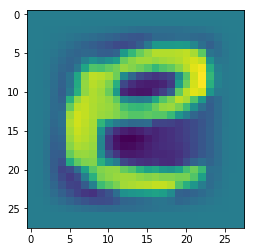

Guess:  	 e
Actually:	 e


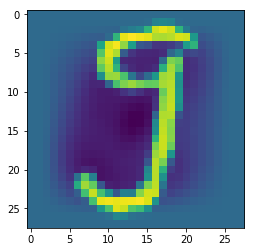

Guess:  	 g
Actually:	 g


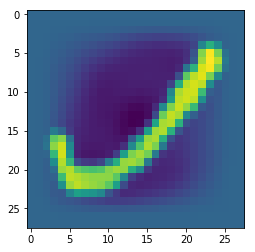

Guess:  	 j
Actually:	 j


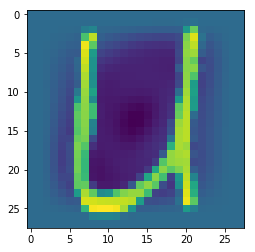

Guess:  	 u
Actually:	 u


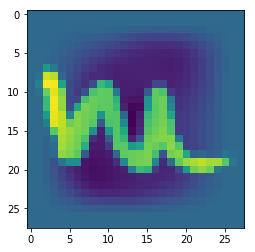

Guess:  	 u
Actually:	 m


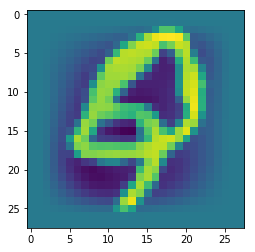

Guess:  	 q
Actually:	 q


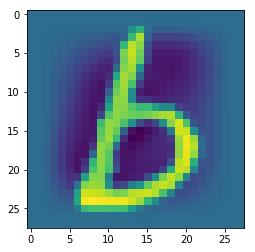

Guess:  	 b
Actually:	 b


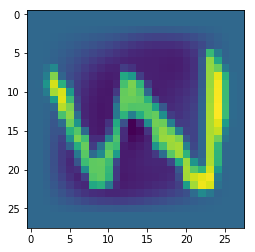

Guess:  	 w
Actually:	 w


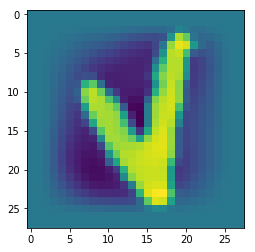

Guess:  	 v
Actually:	 v


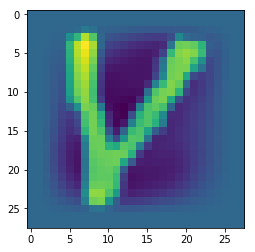

Guess:  	 v
Actually:	 v


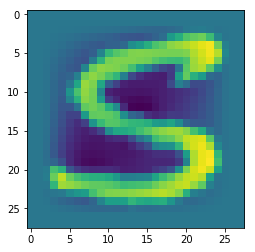

Guess:  	 s
Actually:	 s


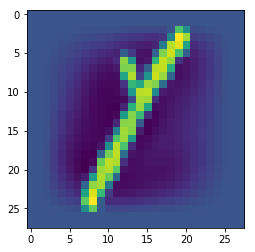

Guess:  	 l
Actually:	 y


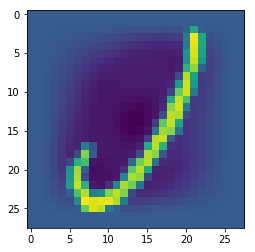

Guess:  	 j
Actually:	 j


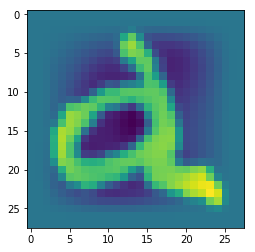

Guess:  	 d
Actually:	 a


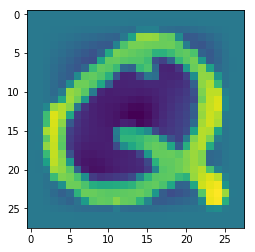

Guess:  	 q
Actually:	 q


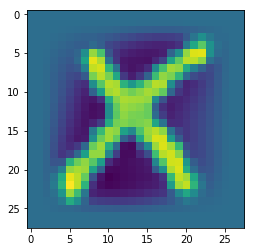

Guess:  	 x
Actually:	 x


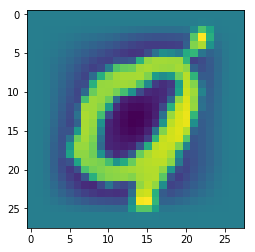

Guess:  	 o
Actually:	 q


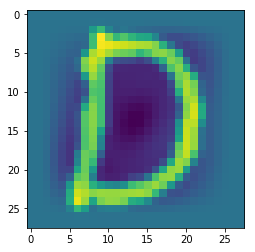

Guess:  	 d
Actually:	 d


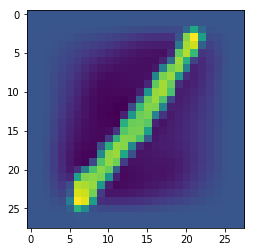

Guess:  	 l
Actually:	 l


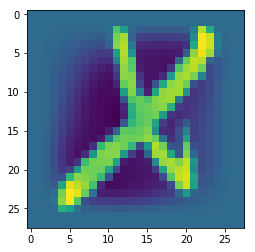

Guess:  	 x
Actually:	 x


In [472]:
for num in range(40,60):
    plt.imshow(valdata[num,:784].reshape((28,28)))
    plt.show()
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    print('Guess:  \t',alphabet[valpredictions[num]-1])
    print('Actually:\t',alphabet[vallabels[num,0]-1])

In [465]:
testdata = np.loadtxt(BASE_DIR+'Data/letters_testdata.csv', dtype=float, delimiter=',')

In [466]:
testpredictions = classifier.predict(testdata)

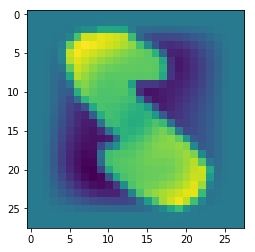

In [467]:
plt.imshow(testdata[0,:784].reshape((28,28)))
plt.show()

In [468]:
def make_kaggle(predictions,kagglecsvfilename,indexing=0):
    # Use this optimal classifier on the test data
    if indexing == 0:
        ids = np.arange(len(predictions))
    elif indexing == 1:
        ids = np.arange(1,len(predictions)+1)
    predictions_csv = np.concatenate(([ids],[predictions]),axis=0).T
    np.savetxt(kagglecsvfilename,predictions_csv,fmt='%i',delimiter=',',header='Id,Category',comments='')
    return predictions_csv

In [469]:
kagglepreds = make_kaggle(testpredictions,BASE_DIR+'Kaggle/neuralnet_mnegus02.csv',indexing=1)

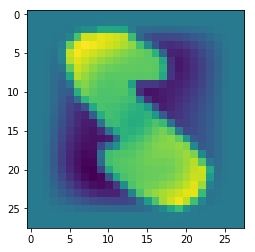

Guess:	 q


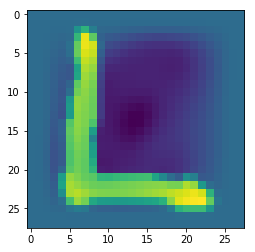

Guess:	 l


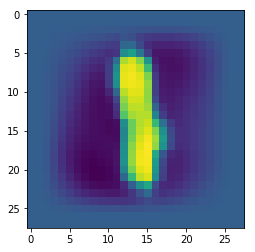

Guess:	 i


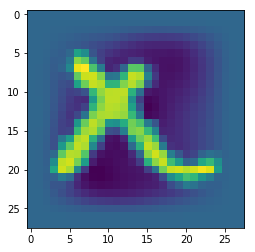

Guess:	 x


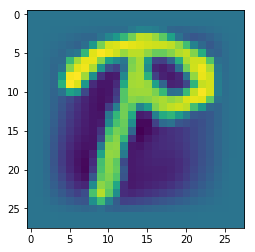

Guess:	 p


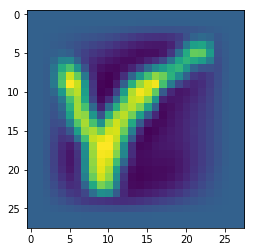

Guess:	 v


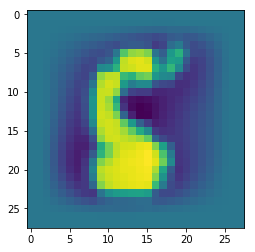

Guess:	 e


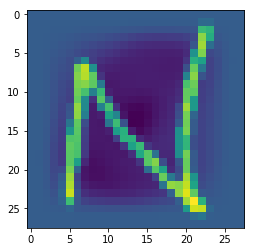

Guess:	 n


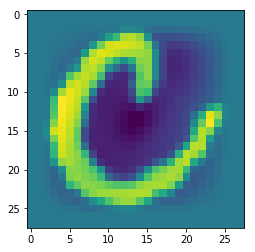

Guess:	 o


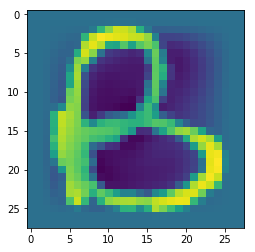

Guess:	 b


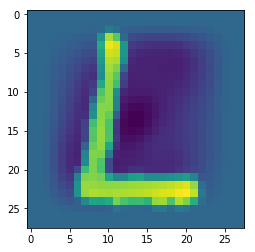

Guess:	 l


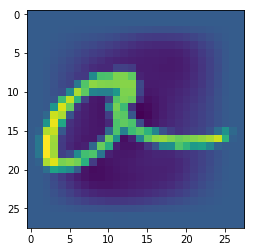

Guess:	 a


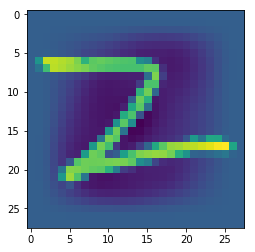

Guess:	 z


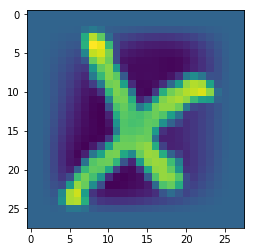

Guess:	 x


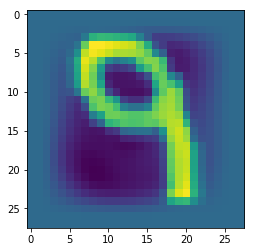

Guess:	 q


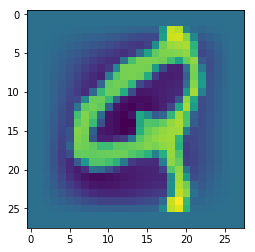

Guess:	 q


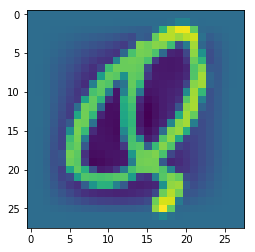

Guess:	 q


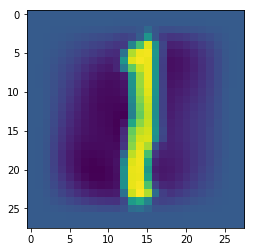

Guess:	 i


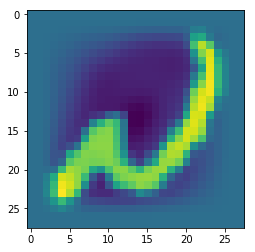

Guess:	 n


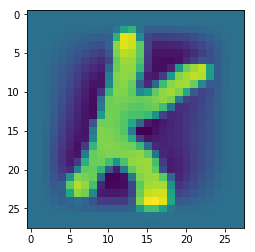

Guess:	 k


In [461]:
for num in range(20):
    plt.imshow(testdata[num,:784].reshape((28,28)))
    plt.show()
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    print('Guess:\t',alphabet[testpredictions[num]-1])